# Using an RL agent to cluster a given set of particles (BYOJ)

Johann Brehmer 2020

## Preparations

In [1]:
import sys
import numpy as np
import logging
import torch

sys.path.append("../")
from ginkgo_rl import GinkgoRLInterface, PolicyMCTSAgent

Let's read INFO-level output from the RL agent, but silence a few other libraries that like to produce lots of logging output. To check what's happening in more detail, use `logging.DEBUG` instead.

In [2]:
logger = logging.getLogger("We")
logging.basicConfig(format="%(asctime)s %(levelname).1s: %(message)s", datefmt="%y-%m-%d %H:%M")

silence_list = ["matplotlib", "showerSim", "hierarchical-trellis"]
for key in logging.Logger.manager.loggerDict:
    logging.getLogger(key).setLevel(logging.INFO)
    for check_key in silence_list:
        if check_key in key:
            logging.getLogger(key).setLevel(logging.ERROR)
            break
            

## Set up GinkgoRLInterface instance

First, let's specify the setup for the environment and the agent. Note that these have to matched the setup in which the agent was trained.

I'm working on documentation...

In [3]:
settings = {
    "n_max": 20,
    "n_min": 2,
    "w_jet": True,
    "w_rate": 3.0,
    "qcd_rate": 1.5,
    "pt_min": 4.0**2,
    "qcd_mass": 30.0,
    "w_mass": 80.0,
    "jet_momentum": 400.0,
    "jetdir": (1, 1, 1),
    "beamsize": 20,
    "n_mc_target": 2,
    "n_mc_max": 50,
    "device": torch.device("cpu"),
}

Path to the state dictionary of the RL agent.

In [4]:
state_dict_filename = "./data/runs/mcts_nn_m_20200930_092039_1010/model.pty"

And finally...

In [5]:
grl = GinkgoRLInterface(state_dict_filename, **settings)

## If you don't have a jet, make one

The whole point of this interface is applying the RL agent to any tree of your choice. However, for convenience (and cross-checks), the `GinkgoRLInterface` class also provides a `generate` function that allows you to generate Ginkgo jets with the settings used.

In [6]:
jets = grl.generate(n=3)

20-12-15 12:56 I: Generating 3 jets
20-12-15 12:56 I: Done


## Run clustering

`GinkgoRLInterface.cluster` is the main function to let the MCTS agent cluster the jets in a jet dictionary. These can be provided as a `dict` object (like we do here) or through the path of a pickled file.

The function returns:
- the clustered jets (as a list of dict objects in the usual Ginkgo style)
- the overall log likelihoods of all reclustered jets
- the number of illegal actions that the RL algorithm picked (hopefully just zeros)
- the computational cost for each jet, measured as the number of evaluations of the splitting likelihood function

If the keyword `filename` is used, the reclustered jets are also pickled to a file.

In [7]:
clustered_jets, log_likelihoods, illegal_actions, costs = grl.cluster(jets, filename="reclustered_jets.pickle")

20-12-15 12:56 I: Clustering 3 jets
100%|██████████| 3/3 [02:00<00:00, 40.07s/it]
20-12-15 12:58 I: Saving clustered jets at reclustered_jets.pickle
20-12-15 12:58 I: Done


## Visualize results

Let's visualize the true and clustered tree using Sebastian's code (make sure that the Ginkgo folder is in the PYTHONPATH).

In [8]:
from scripts import Tree1D_invM as Tree1D

def visualize(jet_top, jet_bottom, label_top="Truth", label_bottom="MCTS"):
    jet_top["node_id"] = jet_top["root_id"]
    jet_bottom["node_id"] = jet_bottom["root_id"]
    
    tree1, tree2 = Tree1D.visualizeTreePair(
        jet_top,
        jet_bottom,
        truthOrder=True, 
        label=True,
        figFormat="jpg",
    )
    tree1.attr(
        rankdir='TB',
        size="10",
        margin='0',
        ratio="0.5",
        nodesep="0.01",
        label=label_top,
        labelloc='t',
        fontsize="36"
    )
    tree2.attr(
        rankdir='BT',
        size="10",
        margin='0',
        ratio="0.5",
        nodesep="0.01",
        label=label_bottom,
        labelloc='b',
        fontsize="36"
    )

    display(tree1)
    display(tree2)


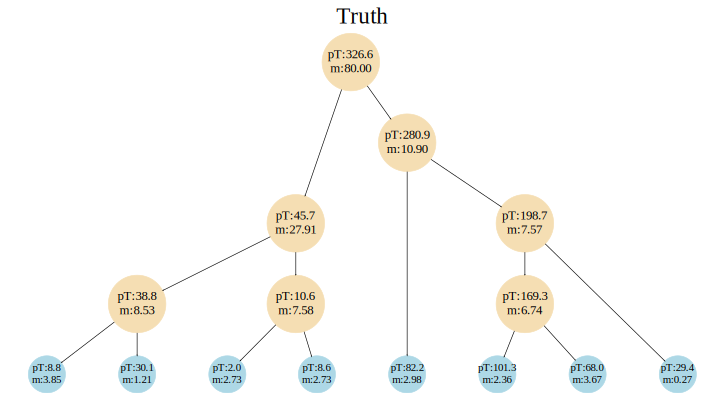

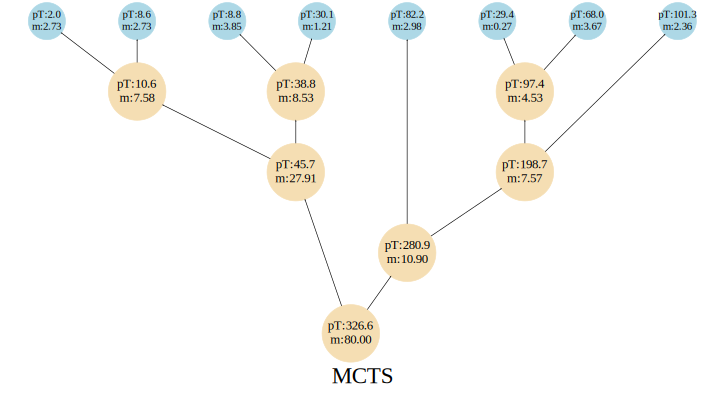

In [11]:
visualize(jets[1], clustered_jets[1])

Finally, let's compare log likelihood numbers:

In [10]:
for jet, log_likelihood in zip(jets, log_likelihoods):
    logger.info(f"Simulator log likelihood: {sum(jet['logLH']):>5.1f}, MCTS log likelihood: {log_likelihood:>5.1f}")
    

20-12-15 12:58 I: Simulator log likelihood: -112.9, MCTS log likelihood: -107.6
20-12-15 12:58 I: Simulator log likelihood: -58.2, MCTS log likelihood: -56.6
20-12-15 12:58 I: Simulator log likelihood: -112.6, MCTS log likelihood: -109.7
